In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
from time import sleep
import math

In [2]:
background = plt.imread("./images/andromeda.jpg")
#li_shape = load_image.shape

#image = np.empty((li_shape[0],li_shape[1],4))

#if len(li_shape) != 3 or li_shape[2] != 4:
#    for m in range(li_shape[0]):
#        for n in range(li_shape[1]):
#            image[m,n,0] = load_image[m,n,0]
#            image[m,n,1] = load_image[m,n,1]
#            image[m,n,2] = load_image[m,n,2]
#            image[m,n,3] = 1
#else:
#    image = load_image
print(background.shape)

(1971, 3000, 3)


In [3]:
fps = 25
spf = 0.04
def draw_image_frame(fig, ax, frame, time=0.04):
    fig.clf()
    plt.imshow(frame, interpolation='None')
    fig.canvas.draw()
    sleep(time)

In [45]:
def magnitude(pt1, pt2):
    return np.sqrt(np.sum(np.square(pt1-pt2)))
#Location/center is a numpy array of size (3,1)
#Mass and raidus is in units of solar mass and solar radii
class blackhole:
    def __init__(self, mass, radius, center): 
        self.mass = mass
        self.radius = radius
        self.center = center
        
    def intersect(self, ray):
        close_origin = ray.traverse(np.dot(self.center-ray.origin,ray.direction))
        return magnitude(close_origin, self.center) < self.radius
        
        
        
class background_image:
    def __init__(self, image, center): 
        self.center = center
        self.image = image
        self.shape = image.shape
        self.normal = np.array([0,0,1])
        
    def intersect(self, ray):
        t = np.dot(np.array([0,0,self.center[2]])-ray.origin, self.normal)/np.dot(ray.direction, self.normal)
        plane_point = ray.traverse(t)
        #print(close_origin)
        within_x = plane_point[0] > -(self.center[0]) and plane_point[0] < self.shape[1]-self.center[0]-1
        within_y = plane_point[1] > -(self.center[1]) and plane_point[1] < self.shape[0]-self.center[1]-1
        #print(plane_point)
        #print(self.center)
        return within_x and within_y 
        
    def intersect_pixel(self, ray):
        #print(ray.direction)
        #print(np.dot(np.array([0,0,self.center[2]])-ray.origin,ray.direction))
        t = np.dot(np.array([0,0,self.center[2]])-ray.origin, self.normal)/np.dot(ray.direction, self.normal)
        plane_point = ray.traverse(t)
        #print(plane_point)
        #print(self.center)
        #print((self.center[0]+plane_point[1]).astype(int), (self.center[1]-plane_point[0]).astype(int))
        return self.image[(self.center[0]+plane_point[1]).astype(int), (self.center[1]-plane_point[0]).astype(int)]
        
        
class ray:
    def __init__(self, origin, pixel):
        self.origin = origin
        self.direction = pixel - origin
    
    def traverse(self, t):
        return self.origin + self.direction*t
        
        
    

[    0 10201     0]


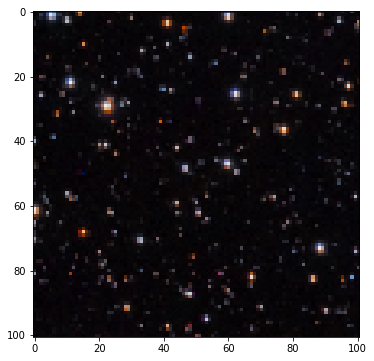

In [48]:
camera_origin = np.array([0, 0, 100])

BHmass = 100
BHradius = 5
BH_loc = np.array([0, 0, -5])

image = np.empty((101,101,3))
image_shape = image.shape
#Main function
BH = blackhole(BHmass, BHradius, BH_loc)
BGimage = background_image(background, np.array([background.shape[1]//2, background.shape[0]//2, -100]))

usages = np.array([0,0,0])
image_center = np.array([math.ceil(image_shape[1]/2), math.ceil(image_shape[0]/2)])
for height in range(image_shape[0]):
    for width in range(image_shape[1]):
        r = ray(camera_origin, np.array([width-image_center[0], height+image_center[1], 0]))
        
        #print(width,height)
        
        if BH.intersect(r):
            image[height, width] = np.array([1,1,1])
            usages[0] += 1
            
        elif BGimage.intersect(r):
            image[height, width] = BGimage.intersect_pixel(r)
            usages[1] += 1
        
        else:
            image[height, width] = np.array([0,0,0])
            usages[2] += 1


image = image.astype(int)
fig = plt.figure(figsize=(10,6))
ax = fig.gca()

draw_image_frame(fig, ax, image)
#print(image)
print(usages)

[[[ 7  5  8]
  [ 6  4  7]
  [10  8  9]
  [10  8  9]
  [ 8  6  7]
  [ 8  6  7]
  [10  8  9]
  [12 10 11]
  [ 9  7 10]
  [ 7  7  9]]

 [[ 7  5  8]
  [ 8  6  7]
  [10  8  9]
  [ 9  7  8]
  [ 7  5  6]
  [10  8  9]
  [10  8  9]
  [11  9 10]
  [ 8  6  7]
  [ 8  8  8]]

 [[11  7  8]
  [ 8  4  5]
  [11  7  8]
  [13  9 10]
  [10  6  7]
  [13  9 10]
  [11  9 10]
  [10  8  9]
  [ 8  6  7]
  [11  9 10]]

 [[12  8  9]
  [ 9  5  6]
  [10  6  7]
  [12  8  9]
  [10  6  7]
  [11  7  8]
  [12  8  9]
  [ 9  7  8]
  [11  9 10]
  [ 9  7  8]]

 [[ 9  5  6]
  [ 8  4  5]
  [ 8  4  5]
  [ 7  3  4]
  [ 9  5  6]
  [ 8  4  5]
  [10  6  7]
  [13  9 10]
  [12 10 11]
  [ 8  6  7]]

 [[10  6  7]
  [ 9  5  6]
  [ 9  5  6]
  [ 9  5  6]
  [11  7  8]
  [ 8  4  5]
  [10  6  7]
  [12  8  9]
  [10  8  9]
  [ 9  7  8]]

 [[11  7  8]
  [11  7  8]
  [12  8  9]
  [12  8  9]
  [11  7  8]
  [10  6  7]
  [12  8  9]
  [10  6  7]
  [11  7  8]
  [11  7  8]]

 [[12  8  9]
  [12  8  9]
  [13  9 10]
  [15 11 12]
  [11  7  8]
  [10  6  7

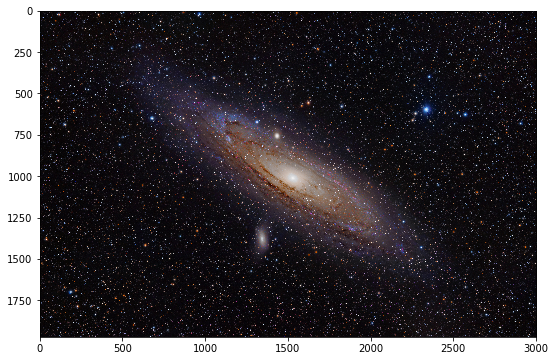

In [40]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()

print(background[:10, :10])

draw_image_frame(fig, ax, background[:, :])

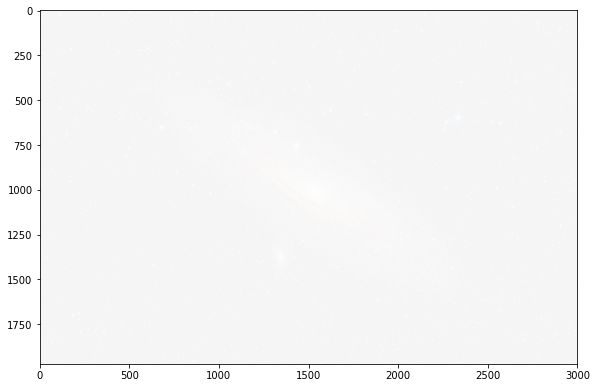

In [47]:
fig = plt.figure(figsize=(10,6.5))
ax = fig.gca()

a = 1.0

for i in range(25):
    fig.clf()
    plt.imshow(image, interpolation='None', alpha=a)
    a = a - 0.04
    fig.canvas.draw()
    sleep(0.04)

In [ ]:
plt.imshow(image, interpolation='None', alpha=0.5)

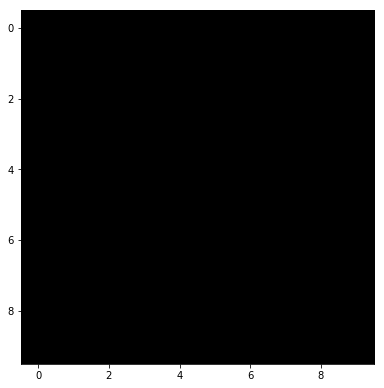

In [61]:
frame_dimensions = (10,10)

frame = np.zeros((frame_dimensions[0], frame_dimensions[0],3))

fig = plt.figure(figsize=(10,6.5))
ax = fig.gca()

draw_image_frame(fig, ax, frame, time=1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
from time import sleep

fig = plt.figure()
ax = fig.gca()
fig.show()

for i in range(10):
    plt.imshow(image, interpolation='None', alpha=a)
    fig.canvas.draw()
    sleep(0.01)